In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# helper functions
sys.path.insert(0, "../src/lib")

import dataset as dataset_funcs
import cleaning as cleaning_funcs

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
sales_df = pd.read_csv('../data/raw/sales.csv')
sales_df.DATE_ORDER = sales_df.DATE_ORDER.astype("datetime64")
sales_df["UNIT_PRICE"] = sales_df["REVENUE"] / sales_df["QTY_ORDER"]
sales_df.sample(5)

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,UNIT_PRICE
55620,P7,2015-06-22,1.000,783.000,783.000
345331,P5,2015-09-24,1.000,776.670,776.670
213915,P2,2015-04-27,1.000,699.000,699.000
80948,P7,2015-01-29,1.000,799.000,799.000
267957,P8,2015-08-19,1.000,379.000,379.000


as we mentioned on the **EXPLORATORY DATA ANALYSIS**, we will remove some bad data from our dataset to avoid propagating these errors to the model (using helper functions).

In [3]:
sales_df = cleaning_funcs.clean_sales_dataframe(sales_df)
sales_df.shape

(351090, 5)

let's split the data into each product (because each product may have different dynamics)

In [4]:
group_ids = ['P1','P2','P3','P4','P5','P6','P7','P8','P9']
grouped = sales_df.groupby([sales_df.PROD_ID])
(p1,p2,p3,p4,p5,p6,p7,p8,p9) = [grouped.get_group(prod_id) for prod_id in group_ids]

let's use P7 in the first run because it's the product the with the most available data

> note that I did not aggregate all entries for a single day into a single row. I could do that but then I would be implying that only daily totals are important, which may or may not reflect actual business objectives.

In [5]:
p7 = p7.sort_values(['DATE_ORDER'])

In [6]:
# now just select the columns we will use in this very simple model
p7 = p7[["UNIT_PRICE","QTY_ORDER"]]

In [7]:
X,y = dataset_funcs.make_Xy_simple(p7)

In [8]:
X.shape,y.shape

((195938, 1), (195938,))

For the first approach I will use a simple linear model (linear regression) without regularization and without cross validation, just to have a high level picture of where we're standing.

In [9]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_absolute_error

> I know I'm not supposed to evaluate the model on the same data I trained it, but here I'm just seeing how it behaves. If this were put to production use, we would need to test it on out of sample data, as per usual.

In [10]:
# I think MAE (mean absolute error) is easier to interpret than MSE (mean squared error)
regr = LinearRegression()
regr.fit(X,y)

MAE = mean_absolute_error(y,regr.predict(y.reshape(-1,1)))

print("MAE for model: {0}".format(MAE))

MAE for model: 0.4455219321585213


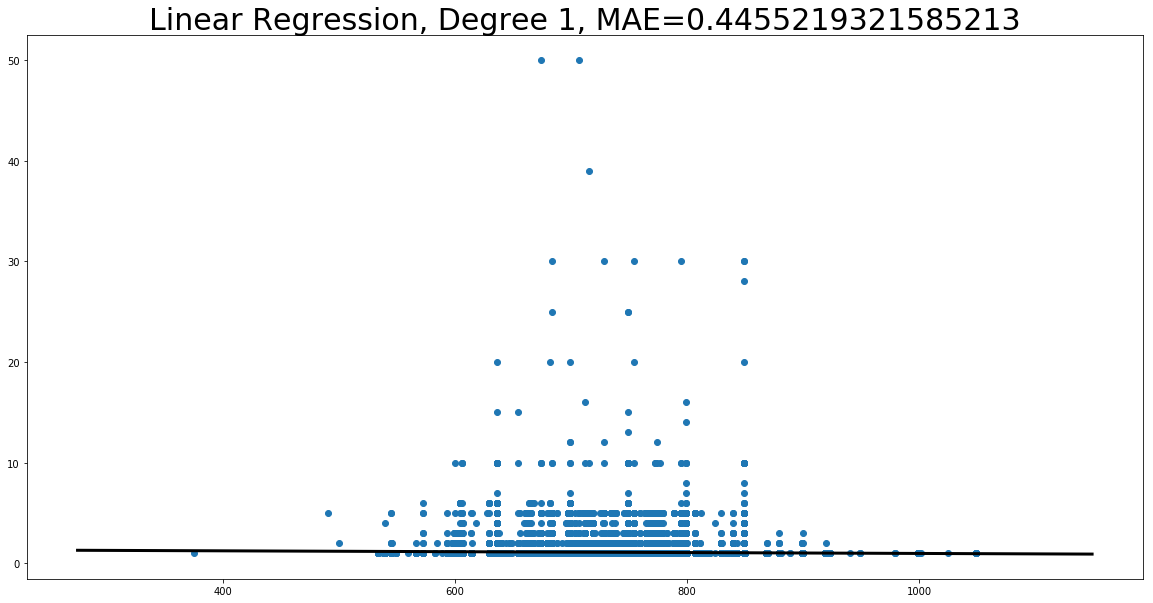

In [11]:
xs = np.linspace(X.min()-100,X.max()+100,10000)
ys = regr.predict(xs.reshape(-1,1))
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X,y)
ax.plot(xs,ys, 'k', lw=3)
plt.title("Linear Regression, Degree 1, MAE={0}".format(MAE),size=30)

comment: linear regression doesn't look like a good strategy here. But before trying a classification approach, let's try and use a General Linear Model (i.e. induce non-linear features) to see if we can get better results.

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [13]:
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

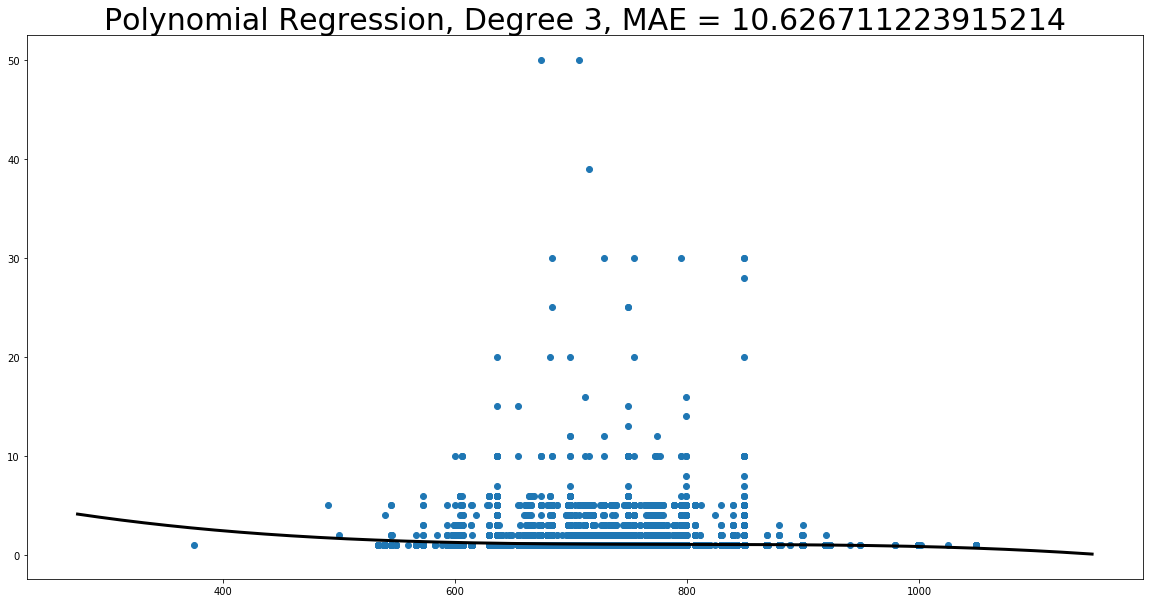

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X.reshape(1,-1),y)
xs = np.linspace(X.min()-100,X.max()+100, 10000)
ys = model.predict(xs.reshape(-1,1))
plt.plot(xs, ys,'k' , linewidth=3)

MAE = mean_absolute_error(y,model.predict(y.reshape(-1,1)))

plt.title("Polynomial Regression, Degree 3, MAE = {0}".format(MAE),size=30)

comment: doesn't look like it's made much difference.

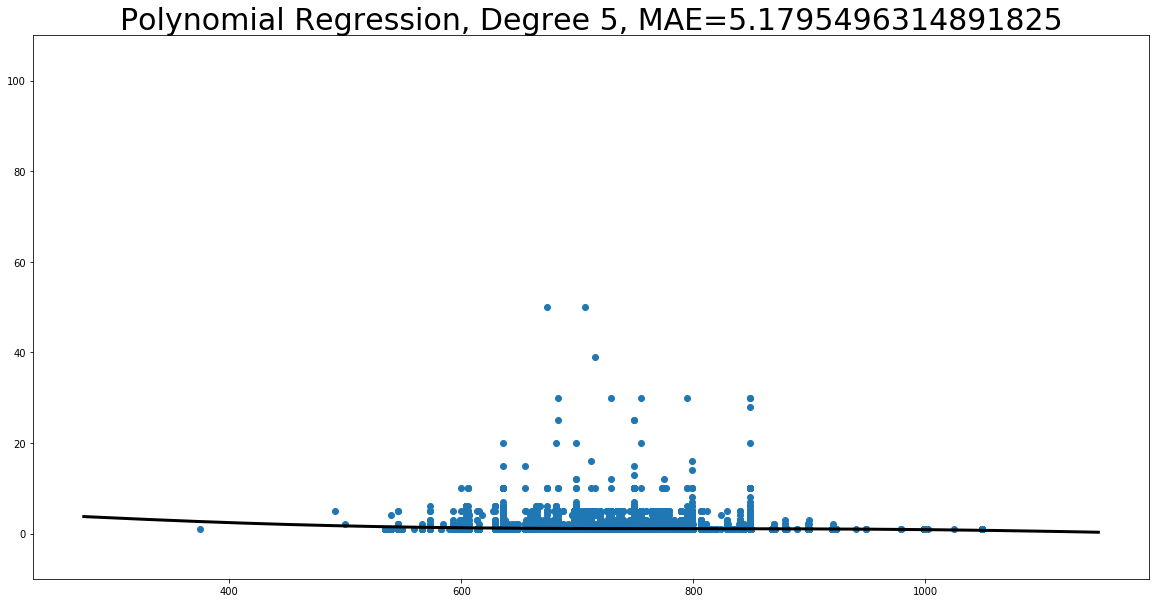

In [15]:
model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(X, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X,y)
xs = np.linspace(X.min()-100, X.max()+100, 10000)
ys = model.predict(xs.reshape(-1,1))
MAE = mean_absolute_error(y,model.predict(y.reshape(-1,1)))
plt.plot(xs, ys,'k' , linewidth=3)
plt.ylim((-10,110))
plt.title("Polynomial Regression, Degree 5, MAE={0}".format(MAE),size=30)

comment: again, no big improvement.

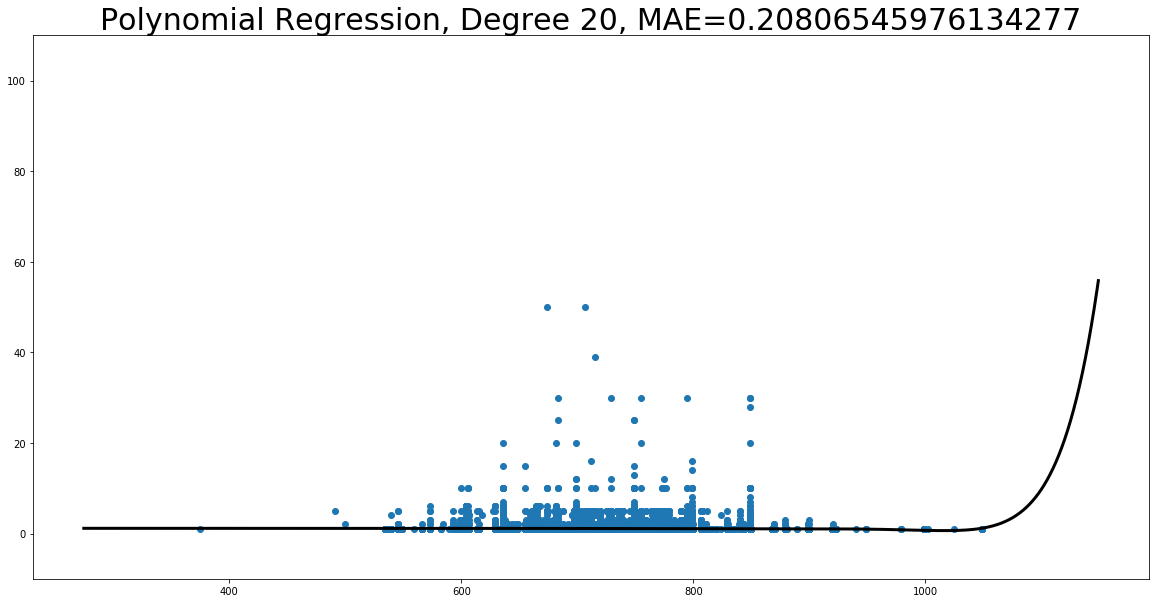

In [16]:
model = make_pipeline(PolynomialFeatures(20), LinearRegression())
model.fit(X, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X,y)
xs = np.linspace(X.min()-100, X.max()+100, 10000)
ys = model.predict(xs.reshape(-1,1))
MAE = mean_absolute_error(y,model.predict(y.reshape(-1,1)))
plt.plot(xs, ys,'k' , linewidth=3)
plt.ylim((-10,110))
plt.title("Polynomial Regression, Degree 20, MAE={0}".format(MAE),size=30)

comment: even if we use a 20th degree polynomial to fit the data, we still get only very slightly MAE than if we used regular 1-degree linear regression (but this helps little because this would very likely cause gross overfitting)